# 6.3 Edmonton AC Loads: Multi-Scenario Analysis

This notebook continues the worked example on analyzing projections of air conditioning loads in Edmonton, using Cooling Degree Days as the climate indicator and weather station data as the observational product. Here we expand the scope of the analysis to include projections not only from multiple CMIP6 models but also for multiple future scenarios. Here is an updated flowchart, generated using the UTCDW survey:

```{image} ./figures/survey_station_multiscenario.png
:width: 600px
:align: center
```

As always, we'll begin by importing the necessary packages and acquiring the observational data.

In [1]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indicators as xci
import xclim.ensembles as xce
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import ec3
import gcsfs
import zarr
import os

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2070, 2101)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

In [2]:
# get the same station data as from 6.1 and 6.2
# The data file will only exist if you've already run
# the code for 6.1
stn_ds = xr.open_dataset('data_files/station_data_edmonton.nc')
stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas
stn_lat = float(stn_ds.lat.values)
stn_lon = float(stn_ds.lon.values)

## 6.3.1 Creating a Multi-Model, Multi-Scenario Ensemble

Now we'll search the catalog for data from the same models as in 6.2, but for multiple SSP scenarios. We'll use the 4 most common SSPs, listed in increasing order of end-of-century radiative forcing:
* SSP1-2.6 (Sustainability)
* SSP2-4.5 (Middle of the Road)
* SSP3-7.0 (Regional Rivalry)
* SSP5-8.5 (Fossil-Fueled Development)

For each model, we'll again use only a single ensemble member. The code below will search the Google Cloud CMIP6 data catalog for ensemble members that include the historical simulation, plus branches for each of the 4 SSPs listed above. For consistency between the historical data and future projections, they must all come from the same ensemble member. 

In [3]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for entries which have daily tas data from the selected scenarios and models
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

models = ['AWI-CM-1-1-MR', 'CESM2', 'CanESM5', 'EC-Earth3', 
          'FGOALS-g3','INM-CM5-0', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']

search_string_mm = "table_id == 'day' & variable_id == 'tas'"
search_string_mm += f" & experiment_id == {scenarios}"
search_string_mm += f"& source_id == {models}"
df_search_mm = df_catalog.query(search_string_mm)

# for each model, select only one ensemble member
df_search_mm = df_search_mm.sort_values('member_id')
df_search_mm_onemember = df_search_mm.drop_duplicates(['source_id', 'experiment_id'], keep = 'first')
df_search_mm_onemember = df_search_mm_onemember.sort_values('source_id')
df_search_mm_onemember

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
203819,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp126,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
203678,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp245,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
204072,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp585,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
203852,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
45210,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
444869,ScenarioMIP,NCAR,CESM2,ssp585,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...,NaN,20200528
445750,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528
66385,CMIP,NCAR,CESM2,historical,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
445868,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370...,NaN,20200528
444314,ScenarioMIP,NCAR,CESM2,ssp126,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp126...,NaN,20200528


In [4]:
# ideally we'd use only one historical ensemble member for each model, and have all the SSP scenarios
# for that model branch from the same historical simulation. This has worked out for most of the models,
# but not IPSL or INM. Let's see if we can find a single member which works for those models

for model in ['IPSL-CM6A-LR', 'INM-CM5-0']:
    print(model)
    # drop the original results for this model from the search results
    where_current_model = df_search_mm_onemember[df_search_mm_onemember.source_id == model].index
    df_search_mm_onemember = df_search_mm_onemember.drop(where_current_model)
    
    search_model = f"source_id == '{model}' & table_id == 'day' & variable_id == 'tas' & experiment_id == {scenarios}"
    df_search_model = df_catalog.query(search_model)
    df_search_model = df_search_model.sort_values('member_id')
    exps_per_member = df_search_model.groupby('member_id').size()
    
    # search for ensemble members that have the same number of entries as there are scenarios in our list
    candidate_members = exps_per_member.loc[exps_per_member == len(scenarios)].index.sort_values()

    # take the first one, if there are any results, and append its entries to the search results
    if len(candidate_members) > 0:
        member = candidate_members[0]
        results_for_this_model = df_search_model[df_search_model.member_id == member]
        df_search_mm_onemember = pd.concat([df_search_mm_onemember, results_for_this_model])
        
df_search_mm_onemember[df_search_mm_onemember.source_id.isin(['IPSL-CM6A-LR', 'INM-CM5-0'])]

IPSL-CM6A-LR
INM-CM5-0


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
389939,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191122
388751,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
388475,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
206789,CMIP,IPSL,IPSL-CM6A-LR,historical,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20190614
386693,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r14i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
206447,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical...,NaN,20190610
209182,ScenarioMIP,INM,INM-CM5-0,ssp245,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190619
244566,ScenarioMIP,INM,INM-CM5-0,ssp585,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190724
208890,ScenarioMIP,INM,INM-CM5-0,ssp370,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190618
209140,ScenarioMIP,INM,INM-CM5-0,ssp126,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/INM/INM-CM5-0/ssp...,NaN,20190619


Having found entries that suit our needs, let's download the data and format it using `xclim.ensembles`.

In [5]:
# function for pre-processing data
def get_and_process_data(catalog_df, model, scenario, gcs, lat, lon, years):
    # get the ztore url for this model and scenario
    df_scen = catalog_df.query(f"source_id == '{model}' & experiment_id == '{scenario}'")
    zstore_url = df_scen.zstore.values[0]
    
    # get the GCS mapper from the url
    mapper = gcs.get_mapper(zstore_url)
    
    # open the file with xarray
    ds = xr.open_zarr(mapper, consolidated = True)
    
    # get the tas data, select the time period, and interp to the desired location
    tas_loc = ds.tas.sel(time = ds.time.dt.year.isin(years)).interp(lat = lat, lon = lon)
    
    # drop 'height' coordinate, which is always 2m but isn't present on all datasets
    if 'height' in tas_loc.coords.keys():
        tas_loc = tas_loc.reset_coords('height', drop = True)
        
    # some datasets put the date at 12:00 whereas some put it at 00:00. To make all
    # of them consistent, simply change the time coordinate to the date only
    tas_loc = tas_loc.assign_coords(time = tas_loc.time.dt.floor('D'))
    # convert from Kelvin to Celsius and return
    
    tas_loc = tas_loc - 273.15
    return tas_loc.compute()

In [6]:
def download_data_multimodel_multiscen(catalog_df, gcs, models, scenarios,
                                       stn_lat, stn_lon,
                                       years_hist, years_future):

    ds_list_hist = []
    ds_list_future = []
    for model in models:
        print(f"========================{model}=============================")
        print('historical')
        tas_model_hist = get_and_process_data(catalog_df, model, 'historical', 
                                              gcs, stn_lat, stn_lon, years_hist)
        ds_list_hist.append(tas_model_hist)
    
        # get the future simulation data for this model, for each scenario
        ds_list_scen = []
        for scenario in scenarios[1:]: # exclude 'historical' from this iteration
            print(scenario)
            tas_model_future = get_and_process_data(catalog_df, model, scenario, 
                                                    gcs, stn_lat, stn_lon, years_future)
            ds_list_scen.append(tas_model_future)
    
        # create ensemble for this one model, where the 'realization' dim represents the different scenarios
        ds_future = xce.create_ensemble(ds_list_scen, realizations = scenarios[1:])
    
        # rename the 'realization' dim
        ds_future = ds_future.rename({'realization': 'scenario'})
        ds_list_future.append(ds_future)
    
    print('finished acquiring model data')
    
    # concatenate the ds_lists together
    ds_ens_hist_raw = xce.create_ensemble(ds_list_hist,                             
                                          realizations = models,
                                          calendar = 'noleap')

    ds_ens_future_raw = xce.create_ensemble(ds_list_future, 
                                          realizations = models,
                                          calendar = 'noleap')

    # rename 'realization' dimension to 'model'
    ds_ens_hist_raw = ds_ens_hist_raw.rename({'realization': 'model'})
    ds_ens_future_raw = ds_ens_future_raw.rename({'realization': 'model'})
    
    # return
    return ds_ens_hist_raw, ds_ens_future_raw

In [7]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# file names to save the downloaded data, to save time later when re-running this notebook
fout_hist = 'data_files/tas.cmip6.daily.historical.1980-2010.edmonton.nc'
fout_future = 'data_files/tas.cmip6.daily.ssp1235.2070-2100.edmonton.nc'

# use the function to download the data, this may take a few minutes to run
if (not os.path.exists(fout_hist)) or (not os.path.exists(fout_future)):
    ds_ens_hist_raw, ds_ens_future_raw = download_data_multimodel_multiscen(df_search_mm_onemember, gcs, models, 
                                                                            scenarios, stn_lat, stn_lon, 
                                                                            years_hist, years_future)

    # write the data to output files 
    ds_ens_hist_raw.to_netcdf(fout_hist)
    ds_ens_future_raw.to_netcdf(fout_future)
else:
    # open the files that already exist
    ds_ens_hist_raw = xr.open_dataset(fout_hist)
    ds_ens_future_raw = xr.open_dataset(fout_future)

## 6.3.2 Exploratory Analysis

With this multi-model, multi-scenario ensemble, we can do much of the same analysis as before and also quantify the effects of scenario uncertainty on future projections. Since the historical validation for this case would be exactly the same as Section 6.2 (since there's only one historical scenario), we can get right into looking at the raw model future projections. Since we already explored model uncertainty in 6.2, let's look at the raw projections of the multi-model ensemble. Remember though that when we get to the bias-correction, it should be applied to each model individually, **not to the multi-model mean**.

In [8]:
# calculate the daily climatology, averaged across models, for the historical and future data
tas_ens_hist_raw = ds_ens_hist_raw.tas
tas_ens_future_raw = ds_ens_future_raw.tas

tas_ensmean_hist_raw_clim = tas_ens_hist_raw.groupby('time.dayofyear').mean(('time', 'model')).compute()
tas_ensmean_future_raw_clim = tas_ens_future_raw.groupby('time.dayofyear').mean(('time', 'model')).compute()

# daily climatology for obs
tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()


# add historical and future scenarios to the same DataArray so the xarray plotting routines show it on the legend
tas_ensmean_hist_raw_clim = tas_ensmean_hist_raw_clim.assign_coords(scenario = 'historical')
tas_clim_model_raw = xr.concat([tas_ensmean_hist_raw_clim, tas_ensmean_future_raw_clim],
                                dim = 'scenario')

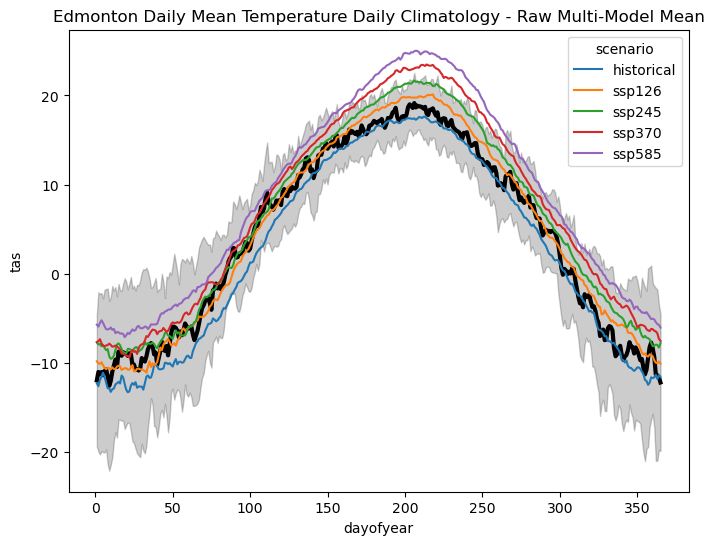

In [9]:
# plot the daily climatologies
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
tas_clim_model_raw.plot.line(ax = ax, hue = 'scenario')


# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'k')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology - Raw Multi-Model Mean")
plt.show()

This plot shows how the multi-model average daily mean temperature climatology varies with the future scenario. The historical climatology (blue) shows a slight cold bias relative to the observations (black), which will hopefully be eliminated after bias-correcting the models. The future scenarios all show warming relative to the historical period, though only the two highest-emission scenarios (SSP3-7.0 and SSP5-8.5) have peaks that exceed the observed range of variability.

We should expect that CDDs will increase under each scenario, and the increases will probably be larger for the higher forcing scenarios. However, we already saw that the inter-model spread for projections was quite large for the single-scenario analysis. Will the spread across scenarios be larger? Let's calculate the CDDs before and after bias-adjustment and investigate.

In [10]:
# assign unit to temperature data
tas_ens_hist_raw.attrs['units'] = 'degC'
tas_ens_future_raw.attrs['units'] = 'degC'
tas_obs_noleap.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs =  xci.atmos.cooling_degree_days(tas_obs_noleap).compute()
cdds_mm_hist_raw = xci.atmos.cooling_degree_days(tas_ens_hist_raw).compute()
cdds_mm_future_raw = xci.atmos.cooling_degree_days(tas_ens_future_raw).compute()

# long-term means 
cdd_obs_ltm = cdd_obs.mean('time')
cdds_mm_hist_raw_ltm = cdds_mm_hist_raw.mean('time')
cdds_mm_future_raw_ltm = cdds_mm_future_raw.mean('time')

# climate change delta
cdds_mm_delta_raw = cdds_mm_future_raw_ltm - cdds_mm_hist_raw_ltm 

# multi-model mean change
cdds_mm_delta_raw_ensmean = cdds_mm_delta_raw.mean('model')

# represent model spread for each scenario by taking stdev across models for the change in long-term means
cdds_mm_delta_raw_model_spread = cdds_mm_delta_raw.std('model')



/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_method

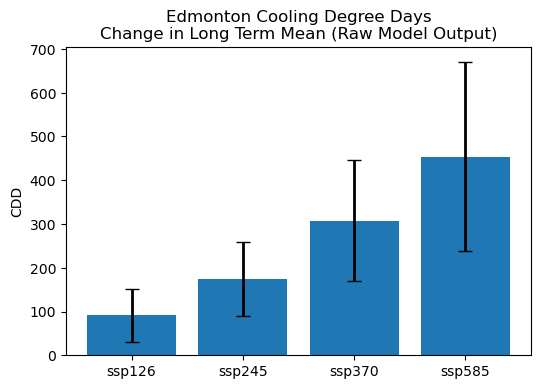

In [11]:
# plot changes to CDDs from the raw model output
fig, ax = plt.subplots( figsize = (6, 4))
ax.set_title("Edmonton Cooling Degree Days\nChange in Long Term Mean (Raw Model Output)")

# plot long-term means
bars = ax.bar(scenarios[1:], cdds_mm_delta_raw_ensmean.values, 
             yerr = cdds_mm_delta_raw_model_spread.values, 
             capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})

ax.set_ylabel('CDD')

plt.show()

In this plot, the blue bars show the multi-model mean change in the average annual CDDs, while the black error bars represent the standard deviation across models for the given scenario. Clearly, scenario uncertainty plays a large role in the overall range of projections, with the low end of the SSP5-8.5 projections not overlapping at all with the high end of the SSP2-1.6 projections. The error bar doesn't overlap with zero for any scenario, so all scenarios project a statistically significant increase in CDDs.

Interestingly, the model spread is larger for the higher forcing scenarios. In other words, the model uncertainty grows with the strength of the forcing. Is that also true for the *percent uncertainty*? Let's check:

In [12]:
cdds_mm_delta_raw_model_spread_pct = (cdds_mm_delta_raw_model_spread / cdds_mm_delta_raw_ensmean) * 100
cdds_mm_delta_raw_model_spread_pct = cdds_mm_delta_raw_model_spread_pct.rename('pct_model_spread_raw')

# mean across scenarios
cdds_mm_delta_raw_model_spread_pct_scenmean = cdds_mm_delta_raw_model_spread_pct.mean('scenario')
cdds_mm_delta_raw_model_spread_pct_scenmean['scenario'] = 'mean'

model_spread_pct = xr.concat([cdds_mm_delta_raw_model_spread_pct, cdds_mm_delta_raw_model_spread_pct_scenmean],
                             dim = 'scenario')

# this will print out the results in a nice table, with the percentages rounded to 2 decimal places
np.around(model_spread_pct, 2).to_dataframe().drop(['lon', 'lat'], axis = 1) 

,pct_model_spread_raw
scenario,
ssp126,65.78
ssp245,48.67
ssp370,45.04
ssp585,47.64
mean,51.78


The above table shows that the percent uncertainty isn't really larger for the higher forcing scenarios. In fact, the scenario with the largest relative model spread is the lowest forcing scenario. Proportionally, model uncertainty is just over 50% averaged across scenarios. 

We can also quantify the relative contribution of scenario uncertainty, by comparing the spread across the different SSPs to the change averaged across scenarios:

In [13]:
cdds_raw_delta_scen_spread = cdds_mm_delta_raw_ensmean.std('scenario')
cdds_delta_raw_scen_spread_pct = (cdds_raw_delta_scen_spread / cdds_mm_delta_raw_ensmean.mean('scenario')) * 100

print(f"Scenario Uncercainty for Raw Model Output: {np.around(cdds_delta_raw_scen_spread_pct.values, 2)}%")

Scenario Uncercainty for Raw Model Output: 53.58%


In the raw model output, it appears that the relative contribution of scenario uncertainty is slightly larger than the typical magnitude of model uncertainty. This isn't so surprising, because the bar chart shows a very large disparity between the high and low forcing scenarios.

We'll re-do these calculations for the bias-adjusted CDD projections to get a final assessment of the magnitude of model uncertainty and scenario uncertainty on the projections.

## 6.3.3 Applying Bias-Correction

Now it's time to apply the QDM bias correction to the model `tas` data. The function call is exactly the same as in the multi-model example because the `xclim` bias-adjustment routines apply separate adjustments over each dimension.

In [14]:
# fix the time axis chunking so xclim won't complain
tas_ens_hist_raw = tas_ens_hist_raw.chunk({'time': -1})
tas_ens_future_raw = tas_ens_future_raw.chunk({'time': -1})

In [15]:
# train and then apply the QDM bias correction
QDM_trained_mscen = sdba.adjustment.QuantileDeltaMapping.train(tas_obs_noleap,     
                                                               tas_ens_hist_raw, 
                                                               nquantiles = 50, 
                                                               kind = "+",
                                                               group = 'time.month' 
                                                              )


tas_ens_hist_qdm = QDM_trained_mscen.adjust(tas_ens_hist_raw,                              
                                            interp = 'linear')

tas_ens_future_qdm = QDM_trained_mscen.adjust(tas_ens_future_raw,                                 
                                              interp = 'linear')

## 6.3.4 Validating Multi-Scenario Downscaled Data

Like the previous examples, we'll start with plotting the daily climatologies. We'll again plot the multi-model mean for each scenario.

In [16]:
# calculate daily climatologies for the multi-model ensemble
tas_clim_hist_qdm = tas_ens_hist_qdm.groupby('time.dayofyear').mean('time').compute()
tas_clim_future_qdm = tas_ens_future_qdm.groupby('time.dayofyear').mean('time').compute()

# multi-model mean
tas_clim_hist_qdm_ensmean = tas_clim_hist_qdm.mean('model')
tas_clim_future_qdm_ensmean = tas_clim_future_qdm.mean('model')

# add historical and future scenarios to the same DataArray so the xarray plotting routines show it on the legend
tas_clim_hist_qdm_ensmean = tas_clim_hist_qdm_ensmean.assign_coords(scenario = 'historical')
tas_clim_model_qdm = xr.concat([tas_clim_hist_qdm_ensmean, tas_clim_future_qdm_ensmean],
                                dim = 'scenario')

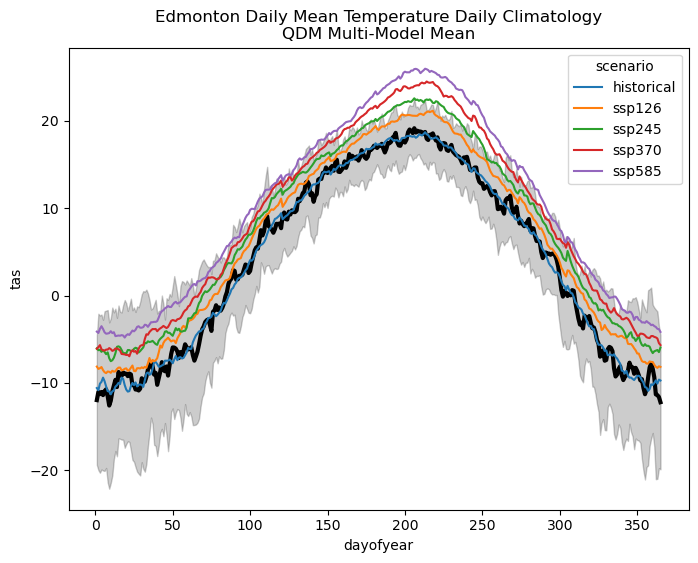

In [17]:
# plot the daily climatologies for all scenarios, QDM
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
tas_clim_model_qdm.plot.line(ax = ax, hue = 'scenario')


# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'k')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology\nQDM Multi-Model Mean")
ax.set_ylabel('tas')
plt.show()

The character of the changes to the daily climatology of `tas` isn't really changed by the bias correction, but the historical multi-model mean (blue) now matches the observed climatology (black) more closely. Next, let's test the statistical significance of mean change to `tas` for each scenario.

In [18]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

neff_hist_qdm = effective_sample_size(tas_ens_hist_qdm).mean('model')
neff_future_qdm = effective_sample_size(tas_ens_future_qdm).mean('model')

In [19]:
# calculate mean and stdev for downscaled historical and future tas
tas_ens_hist_qdm_mean = tas_ens_hist_qdm.mean(('model', 'time'))
tas_ens_hist_qdm_stdev = np.sqrt(tas_ens_hist_qdm.var('time').mean('model'))

tas_ens_future_qdm_mean = tas_ens_future_qdm.mean(('model', 'time'))
tas_ens_future_qdm_stdev = np.sqrt(tas_ens_future_qdm.var('time').mean('model'))

# perform two_sample t-test to see if future temperatures are higher than past
pvals = []
for scenario in tas_ens_future_qdm_mean.scenario.values:
    tstat, pval = stats.ttest_ind_from_stats(tas_ens_future_qdm_mean.sel(scenario = scenario), 
                                            tas_ens_future_qdm_stdev.sel(scenario = scenario), 
                                            neff_future_qdm.sel(scenario = scenario), 
                                            tas_ens_hist_qdm_mean,
                                            tas_ens_hist_qdm_stdev,
                                            neff_hist_qdm, 
                                            equal_var = False,
                                            alternative = 'greater') 
    pvals.append(pval)

pd.DataFrame.from_dict({'scenario': tas_ens_future_qdm_mean.scenario.values, 'p-value': np.around(pvals, 4)})

,scenario,p-value
0,ssp126,0.0198
1,ssp245,0.0005
2,ssp370,0.0000
3,ssp585,0.0000


The increase in mean `tas` is significant for all scenarios. 

## 6.3.5 Downscaled Indicator for Multiple Scenarios
Next, let's examine the changes to CDDs.

In [20]:
tas_ens_hist_qdm.attrs['units'] = 'degC'
tas_ens_future_qdm.attrs['units'] = 'degC'

cdds_hist_qdm = xci.atmos.cooling_degree_days(tas_ens_hist_qdm).compute()
cdds_future_qdm = xci.atmos.cooling_degree_days(tas_ens_future_qdm).compute()

# long-term means
cdds_hist_qdm_ltm = cdds_hist_qdm.mean('time')
cdds_future_qdm_ltm = cdds_future_qdm.mean('time')

# climate change deltas
cdds_qdm_delta = cdds_future_qdm_ltm - cdds_hist_qdm_ltm

# multi-model mean delta
cdds_qdm_delta_ensmean = cdds_qdm_delta.mean('model')

# stdev across models for delta
cdds_qdm_delta_stdev = cdds_qdm_delta.std('model')

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env2/lib/python3.12/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


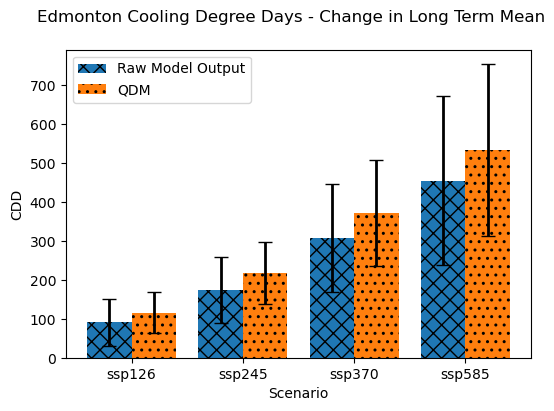

In [21]:
# plot changes to CDDs from QDM data AND raw model data, next to each other
fig, ax = plt.subplots(figsize = (6, 4), sharex = True, sharey = True)
fig.suptitle("Edmonton Cooling Degree Days - Change in Long Term Mean")

# dummy x-axis values, which will be replaced by the scenario names later on.
# we need to use these in order to have the bars for the two scenarios side-by-side
# on the same axis
xx = np.arange(len(scenarios[1:]))
width = 0.4

# raw model changes
bars_raw = ax.bar(xx, cdds_mm_delta_raw_ensmean.values, width, 
                  yerr = cdds_mm_delta_raw_model_spread.values, 
                   # add hatching to make the two bars differ visually in another way than just the colour.
                   # this helps make the plots more colorblind-friendly
                  label = "Raw Model Output", hatch = 'xx',
                  capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})

# QDM changes, plotted immediately to the right of the raw changes for the same scenario
bars_qdm = ax.bar(xx + width, cdds_qdm_delta_ensmean.values, width, 
                  yerr = cdds_qdm_delta_stdev.values, 
                  label = "QDM", hatch = '..',
                  capsize = 5, error_kw = {'ecolor': 'k', 'elinewidth': 2})


# set up the x-tick labels (scenario names) to be in the middle of the two bars
ax.set_xticks(xx + width/2)
ax.set_xticklabels(scenarios[1:])

# axis labels and legend 
ax.set_ylabel('CDD')
ax.set_xlabel('Scenario')
ax.legend()

plt.show()

The effect of the bias correction was to increase the magnitude of the CDD projections for each scenario, though the size of the model spread and scenario spread appear mostly unchanged. As we did for the raw model projections, we can quantify the relative contributions of model uncertainty and scenario uncertainty by comparing the spread across models/scenarios to the mean change across models/scenarios.

In [22]:
cdds_delta_qdm_model_spread_pct = (cdds_qdm_delta_stdev / cdds_qdm_delta_ensmean) * 100
cdds_delta_qdm_model_spread_pct = cdds_delta_qdm_model_spread_pct.rename('pct_model_spread_qdm')

cdds_delta_qdm_model_spread_pct_scenmean = cdds_delta_qdm_model_spread_pct.mean('scenario')
cdds_delta_qdm_model_spread_pct_scenmean['scenario'] = 'mean'

model_spread_pct_qdm = xr.concat([cdds_delta_qdm_model_spread_pct, cdds_delta_qdm_model_spread_pct_scenmean],
                                  dim = 'scenario')
np.around(model_spread_pct_qdm, 2).to_dataframe().drop(['lon', 'lat'], axis = 1)

,pct_model_spread_qdm
scenario,
ssp126,44.52
ssp245,36.27
ssp370,36.62
ssp585,41.25
mean,39.67


In [23]:
cdds_qdm_delta_scen_spread = cdds_qdm_delta_ensmean.std('scenario')
cdds_delta_qdm_scen_spread_pct = (cdds_qdm_delta_scen_spread / cdds_qdm_delta_ensmean.mean('scenario')) * 100

print(f"Scenario Uncercainty After Bias-Adjustment: {np.around(cdds_delta_qdm_scen_spread_pct.values, 2)}%")

Scenario Uncercainty After Bias-Adjustment: 51.02%


After applying the bias correction, the spread in projections across both models and scenarios is reduced, but scenario uncertainty still dominates model structural uncertainty, and now to a much greater extent. Therefore we'll use the spread across scenarios to generate our final range of changes to CDDs in Edmonton, from the historical baseline period to the end of the 21st century. Again we'll use the 10th-90th percentile range to produce the overall uncertainty range, just this time across scenarios. 

In [24]:
cdd_change_10p = cdds_qdm_delta_ensmean.quantile(0.1, dim = 'scenario')
cdd_change_90p = cdds_qdm_delta_ensmean.quantile(0.9, dim = 'scenario')

# multi-model mean historical CDDs
cdds_hist_qdm_ltm_mm_mean = cdds_hist_qdm_ltm.mean('model')

results_str = "Likely Range of Mean CDD Change from 1980-2010 to 2070-2100: "
results_str += f"{int(np.around(100 * cdd_change_10p.values/cdds_hist_qdm_ltm_mm_mean.values, 0))}% to "
results_str +=f"{int(np.around(100 * cdd_change_90p.values/cdds_hist_qdm_ltm_mm_mean.values, 0))}%"

print(results_str)

Likely Range of Mean CDD Change from 1980-2010 to 2070-2100: 170% to 564%


The size of this projection range is similar to the range across models in Section 6.2, but because we're considering some weaker forcing scenarios, the magnitude of the changes is smaller than for the SSP3-7.0 scenario alone. 

Including multiple models and scenarios in this analysis has allowed us to characterize uncertainty in the future projections - something we couldn't do in the previous examples where either only one model or one scenario was investigated. 

So far none of the examples have assessed the contribution of internal climate variability to the uncertainty in future projections. For an end-of-century projection period and a variable like daily mean temperature which has a robust climate change signal, it's unlikely that internal variability would be comparable to model or scenario uncertainty. However, internal variability can be very important for near-term projections, when the magnitude of the climate change signal may not yet exceed the range of historical variability. In the next section, we'll attempt to prove this by using multiple realizations for a single model.